# Scratch Notebook for Predictions module

In [46]:
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

%matplotlib inline

In [2]:
def standardize_windows(array):
    return (array / array[0]) - 1

In [86]:
def load_data(ticker, filename='data/total_data.csv', standardize=True):
    
    '''
    File rows: Ticker, Start Date, End Date, Sector, Industry, Pattern, Dollar, Interest, Volatility, Prices (window = [0:40], target = [40])
    '''
    raw_data = open(filename).read().split('\n')
    raw_data.pop()
    
    data = [row.split(',') for row in raw_data]
    
    tickers = np.array([info[0] for info in data]).astype(str)
    date_pairs = np.array([(info[1], info[2]) for info in data]).astype(np.datetime64)
    sectors_str = np.array([info[3] for info in data]).astype(str)
    industries_str = np.array([info[4] for info in data]).astype(str)
    patterns_str = np.array([info[5] for info in data]).astype(str)
    dollars = np.array([info[6] for info in data]).astype(float)
    interests = np.array([info[7] for info in data]).astype(float)
    vols = np.array([info[8] for info in data]).astype(float)
    prices = np.array([info[9:] for info in data]).astype(float)
    
    le = LabelEncoder()
    sectors_encoded = le.fit_transform(sectors_str)
    #industries_encoded = le.fit_transform(industries_str)
    patterns_encoded = le.fit_transform(patterns_str)
    
    if standardize:
        std_prices = np.apply_along_axis(standardize_windows, 1, prices)
    
    indicies = np.argwhere(tickers==ticker).flatten()
    
    aux_data = np.array(list(zip(sectors_encoded[indicies], patterns_encoded[indicies], dollars[indicies], interests[indicies], vols[indicies])))
    
    return sectors_str[0], industries_str[0], date_pairs[indicies], patterns_str[indicies], aux_data, prices[indicies], std_prices[indicies]


def predict_sequences_aux(model, data, prediction_length, window_size=40):
    prediction_seqs = []
    for i in range(int(len(data[0])/prediction_length)):
        curr_frame_ts = data[0][i*prediction_length]
        #curr_frame_aux = data[1][i*prediction_length]
        predicted = []
        for j in range(prediction_length):
            predicted.append(model.predict([curr_frame_ts[np.newaxis,:,:], data[1][i*prediction_length+j][np.newaxis,:]])[0,0])
            curr_frame_ts = curr_frame_ts[1:]
            curr_frame_ts = np.insert(curr_frame_ts, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def predict_sequences_simple(model, data, prediction_length, window_size=40):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_length)):
        curr_frame = data[i*prediction_length]
        predicted = []
        for j in range(prediction_length):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data, prediction_length):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    #fig.autofmt_xdate()
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_length)]
        plt.plot(padding + data, label='Prediction', style='r')
        #plt.legend()
    #plt.savefig('%s.png' % ticker)
    #plt.gcf().autofmt_xdate
    #xfmt = mdates.DateFormatter('%Y-%m-%d')
    #ax.axis.set_major_formatter(xfmt)
    plt.show()
    
def plot_results_(ticker, patterns, predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction', color='r')
        #plt.legend()
    plt.xlabel('Days')
    plt.ylabel('Price (Standardized)')
    
    plt.title('%s [%s]' % (ticker, ', '.join(patterns)))
    plt.show()
        
def find_index(date):
    index = np.argwhere(date_pairs[:,0]==date)
    count = 1
    while not index:
        index = np.argwhere(date_pairs[:,0]==date+count)
        count += 1
    return index[0][0]

In [34]:
ticker = 'AMZN' #str(input('Ticker: ')).upper()
start_date = np.datetime64('2000-03-10') #str(input('Start date (YYYY-MM-DD): ')))
end_date = np.datetime64('2000-07-10') #str(input('End date (YYYY-MM-DD): ')))
model_type = 'aux'
epochs = 10 #int(input('Epochs: '))
prediction_length = 10 #int(input('Prediction Length (days): '))

#sector, industry, date_pairs, patterns, aux_data, prices, std_prices = load_data(ticker)

aux_model = load_model('final_models/final_aux_10.hdf5')
simple_model = load_model('final_models/final_simple_10.hdf5')

start_index = find_index(start_date)
end_index = find_index(end_date)

dates = [d[0] for d in date_pairs[start_index:end_index]]
patterns = set((pattern for pattern in patterns[start_index:end_index]))

x_test = std_prices[start_index:end_index, :-1]
y_test = std_prices[start_index:end_index, -1]
x_test_aux = aux_data[start_index:end_index]

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test_aux = np.reshape(x_test_aux, (x_test_aux.shape[0], x_test_aux.shape[1]))


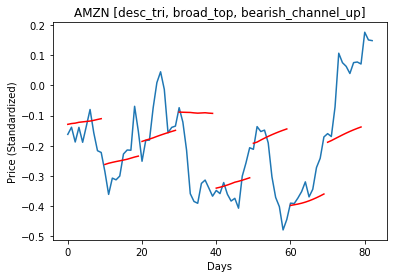

In [87]:
predictions = predict_sequences_aux(aux_model, [x_test, x_test_aux], prediction_length)
plot_results_(ticker, patterns, predictions, y_test, prediction_length)

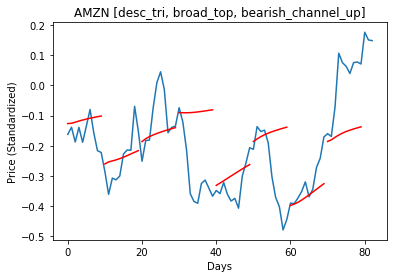

In [89]:
predictions = predict_sequences_simple(simple_model, x_test, prediction_length)
plot_results_(ticker, patterns, predictions, y_test, prediction_length)